<a href="https://colab.research.google.com/github/jieren123/IntroQuantumComputation/blob/Final_Project/Final_Project_QML_USOptionCall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Quantum Amplitude Estimation
! pip install qiskit
! pip install qiskit_finance
import qiskit
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem

low:107.99769476156862
high:192.52056059041323


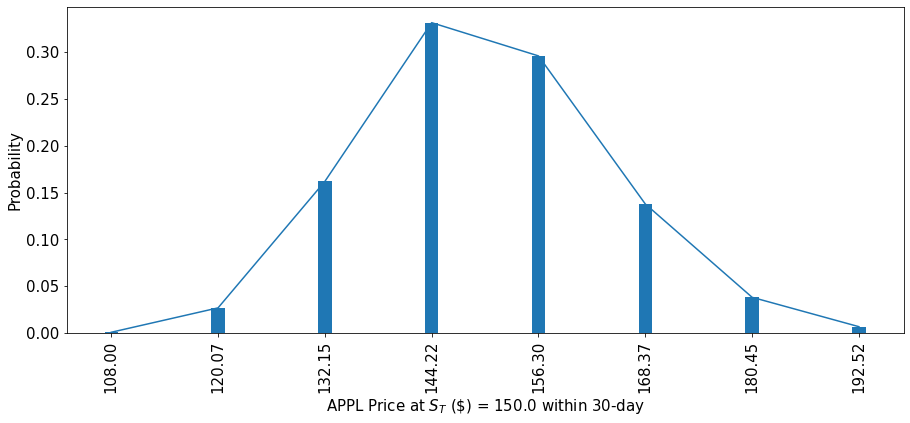

In [ ]:
# number of qubits 
num_qubits = 3

# parameters for considered random distribution
S = 150.0  # initial spot price
vol = 0.3263  # implied volatility of 32% close-to-close 30 Days 
r = 0.021  # annual interest rate of 2.1% in 2022
T = 30 / 365  # one month to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

print("low:{}".format(low))
print("high:{}".format(high))

# construct A operator for QAE for the payoff function by
AmericanCallOption_model = LogNormalDistribution(num_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

# plot probability distribution
plt.figure(figsize = (15, 6))
x = AmericanCallOption_model.values
y = AmericanCallOption_model.probabilities
plt.bar(x, y, width = 1.5)
plt.plot(x, y, linestyle='solid')
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.xlabel("{} Price at $S_T$ (\$) = {} within 30-day".format("APPL", S), size = 15)
plt.ylabel("Probability", size=15)
plt.show()

In [ ]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 140

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
AmericanCallOption_objective = LinearAmplitudeFunction(
    num_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits_ = AmericanCallOption_objective.num_qubits
us_call = QuantumCircuit(num_qubits_)
us_call.append(AmericanCallOption_model, range(num_qubits))
us_call.append(AmericanCallOption_objective, range(num_qubits_))

# draw the circuit
us_call.draw()

┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │       ││    │
q_1: ┤1 P(X) ├┤1   ├
     │       ││    │
q_2: ┤2      ├┤2   ├
     └───────┘│    │
q_3: ─────────┤3 F ├
              │    │
q_4: ─────────┤4   ├
              │    │
q_5: ─────────┤5   ├
              │    │
q_6: ─────────┤6   ├
              └────┘

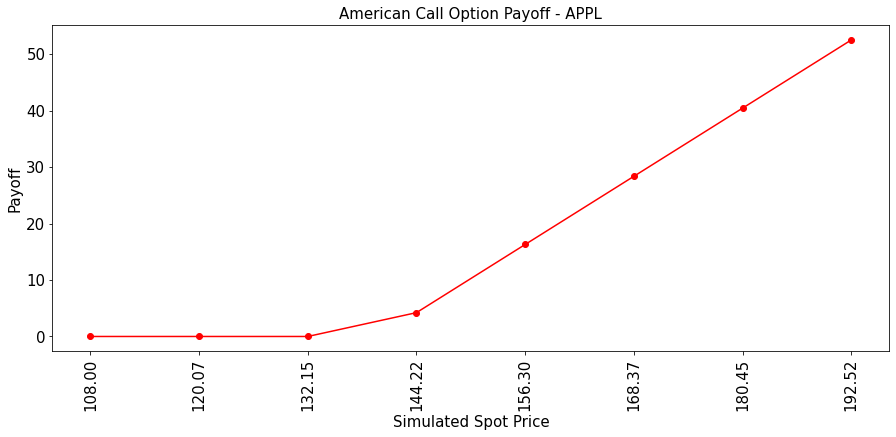

In [ ]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = AmericanCallOption_model.values
y = np.maximum(0, x - strike_price)
plt.figure(figsize = (15, 6))
plt.plot(x, y, "ro-")
# plt.grid()
plt.title("American Call Option Payoff - APPL", size=15)
plt.xlabel("Simulated Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [ ]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(AmericanCallOption_model.probabilities, y)
exact_delta = sum(AmericanCallOption_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	12.0486
exact delta value:   	0.8099


In [ ]:
# Evaluate Expected Payoff
us_call.draw()
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=us_call,
    objective_qubits=[3],
    post_processing=AmericanCallOption_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	12.0486
Estimated value:    	12.4130
Confidence interval:	[11.3464, 13.4796]
